In [6]:
%config Completer.use_jedi = False

PROJECT_ROOT = "/home/vladislav/experiments/texts-similarity"

In [7]:
import sys  
sys.path.insert(1, PROJECT_ROOT)

In [11]:
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity

import torch
import numpy as np
import pandas as pd
import pickle

In [12]:
def bert(df, model_name):
    model = BertModel.from_pretrained(model_name)
    tokenizer = BertTokenizer.from_pretrained(model_name)
    doc = df[['answer']].values
    eta_answer = df[['true_answer']].values[0]
    X = []
    y = df[['mark']].values

    encoded_input = tokenizer(eta_answer[0], return_tensors='pt')
    with torch.no_grad():
        last_hidden_states = model(**encoded_input)[0]
    eta_answer = last_hidden_states.mean(1)
    
    for row in doc:
        encoded_input = tokenizer(row[0], return_tensors='pt')
        with torch.no_grad():
            last_hidden_states = model(**encoded_input)[0]
        embedding = last_hidden_states.mean(1)
        X.append(embedding)
        
    X = [embedding.numpy()[0] for embedding in X]
    
    print(f"{model_name} DONE")
    return {"X": np.array(X), "y": list(map(lambda x: x[0], y)), "true_answer": eta_answer.numpy()[0]}


In [56]:
bert_models = [
    "bert-base-multilingual-cased",
    "bert-base-multilingual-uncased",
    "ai-forever/ruBert-large",
]
df = pd.read_csv(f"{PROJECT_ROOT}/small_binary_corpus.csv")
res = None
for model in bert_models:
    res = bert(df, model)
    with open(f"{model.replace("/", "_")}-embeddings.pickle", "wb") as file:
        pickle.dump(res, file)
        

bert-base-multilingual-cased DONE
bert-base-multilingual-uncased DONE
ai-forever/ruBert-large DONE


In [58]:
with open("bert-base-multilingual-cased-embeddings.pickle", "rb") as file:
    res = pickle.load(file)
X = res["X"]
true_answer = res["true_answer"]
y = res["y"]

preds = []
for i in range(len(X)):
    preds.append(cosine_similarity([X[i]], [true_answer])[0][0])

In [82]:
from sklearn.metrics import precision_score, recall_score, f1_score

precisions = []
recalls = []
f1s = []
limits = []
for i in range(20):
    for j in range(10):
        limit = -1 + i / 10 + j / 100
        limits.append(limit)
        limited_preds = np.array([1 if pred > limit else 0 for pred in preds])
        precision = precision_score(y, limited_preds, average="binary", zero_division=0)
        recall = recall_score(y, limited_preds, average="binary", zero_division=0)
        f1 = f1_score(y, limited_preds, average="binary", zero_division=0)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
print(sum(y) / len(y))

0.875


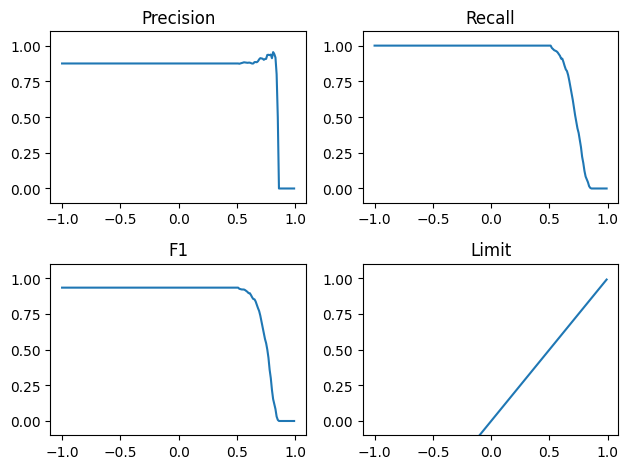

In [83]:
import matplotlib.pyplot as plt

X = limits

Y1 = precisions
Y2 = recalls
Y3 = f1s

figure, axis = plt.subplots(2, 2)

axis[0, 0].plot(X, Y1)
axis[0, 0].set_title("Precision")
axis[0, 0].set_ylim((-0.1, 1.1))

axis[0, 1].plot(X, Y2)
axis[0, 1].set_title("Recall")
axis[0, 1].set_ylim((-0.1, 1.1))

axis[1, 0].plot(X, Y3)
axis[1, 0].set_title("F1")
axis[1, 0].set_ylim((-0.1, 1.1))

axis[1, 1].plot(X, X)
axis[1, 1].set_title("Limit")
axis[1, 1].set_ylim((-0.1, 1.1))

figure.tight_layout()
plt.show()

In [84]:
max_prec = max(precisions)
max_rec = max(recalls)
max_f1 = max(f1s)

prec_lim = limits[len(f1s) - precisions[::-1].index(max_prec)]
rec_lim = limits[len(f1s) - recalls[::-1].index(max_rec)]
f1_lim = limits[len(f1s) - f1s[::-1].index(max_f1)]

print(max_prec)
print(max_rec)
print(max_f1)
print()
print(prec_lim)
print(rec_lim)
print(f1_lim)


0.9545454545454546
1.0
0.9333333333333333

0.8200000000000001
0.52
0.52


In [85]:
print(limits.index(0.5))

150


In [86]:
print(f1s[15])
print(precisions[15])
print(recalls[15])

0.9333333333333333
0.875
1.0


In [72]:
print(fn)

0
